In [1]:
import pandas as pd

target = "METADATA_mode_of_action"
take_model = "catboost_model.cbm"

In [2]:
wd = "/home/ec2-user/picassoxbridgedata_coupled/s3_multi_omics/merged_transcriptomics_cellpainting/"
transcriptomics_chemistry_and_meta_mofa = (
    f"{wd}features/lyon_transcriptomics_chemistry_mofa_and_meta.csv.gz"
)
train_metadata = f"{wd}meta/multiomics_combined_metadata_train.csv"
test_metadata = f"{wd}meta/multiomics_combined_metadata_test.csv"
df = pd.read_csv(transcriptomics_chemistry_and_meta_mofa, index_col=0)
plot_dir = "/home/ec2-user/picassoxbridgedata_coupled/s3_multi_omics/multiomics_analyses/ml_plots/"

In [3]:
chem_columns = df.columns[df.columns.str.startswith("CHEM")].to_list()
gene_columns = df.columns[df.columns.str.startswith("GE")].to_list()
cp_columns = df.columns[df.columns.str.startswith("CP")].to_list()
meta_columns = df.columns[df.columns.str.startswith("META")].to_list()
mofa_columns = df.columns[df.columns.str.startswith("MOFA")].to_list()

In [4]:
prefix_dict = {
    "GE": "Gene Expression",
    "CHEM": "Chemistry",
    "CP": "Cell Painting",
    "MOFA": "MoFa Factor",
}

In [5]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = df[df[target].notnull()]
X = df[gene_columns + cp_columns + mofa_columns]
X = X.fillna(X.median(axis=0))
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

if take_model == "":
    # Initialize the CatBoostClassifier
    model = CatBoostClassifier(
        iterations=1000,
        thread_count=16,
        early_stopping_rounds=50,
    )

    # Fit the model on the training data with validation set
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy on the test set: {accuracy:.4f}")
    # Save the model to a file in CatBoost's native format
    from sklearn.metrics import classification_report

    print(classification_report(y_test, y_pred))
    model.save_model(f"catboost_model_{target}.cbm")
else:
    # Load the model from the file
    model = CatBoostClassifier()
    # model.load_model(f"catboost_model_{target}.cbm")
    model.load_model(take_model)

In [6]:
feature_importance = model.feature_importances_
feature_df = pd.DataFrame(
    {
        "feature": X_test.columns,
        "importance": feature_importance,
    }
)
feature_df = feature_df.sort_values("importance", ascending=False).head(100)

/tmp/ipykernel_130055/751834801.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df.head(30), x="importance", y="feature", palette="rainbow")
/tmp/ipykernel_130055/751834801.py:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


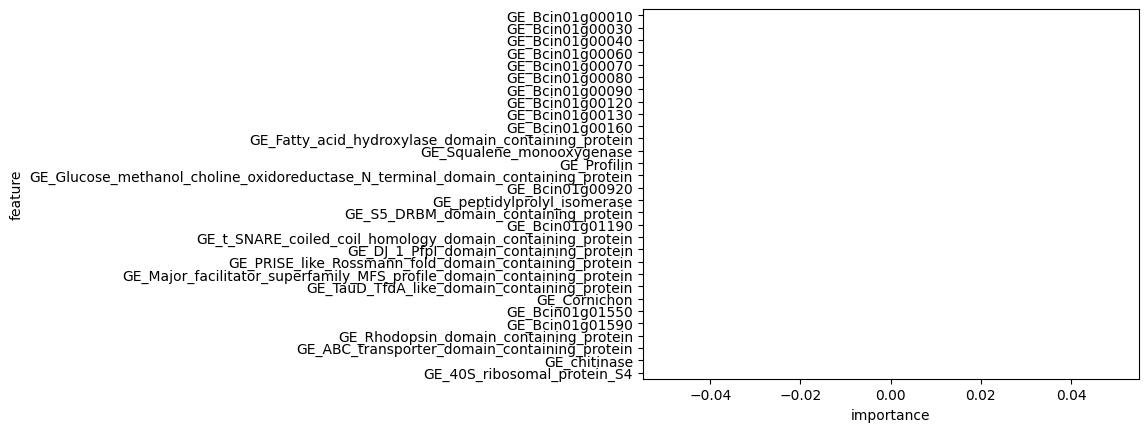

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=feature_df.head(30), x="importance", y="feature", palette="rainbow")
plt.tight_layout()

In [8]:
target_class = y_test.unique()[0]

In [11]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from catboost import Pool
import shap
import numpy as np


def train_class_vs_dmso(X_train, y_train, X_test, y_test, target_class):
    """
    Train a CatBoost model to differentiate a target class from DMSO.

    Parameters:
    - X_train: Features for training
    - y_train: Target variable for training
    - X_test: Features for testing
    - y_test: Target variable for testing
    - target_class: The class to differentiate from DMSO

    Returns:
    - model: Trained CatBoost model
    - accuracy: Accuracy of the model on the test set
    """

    # Create binary target variables
    X_train_target = X_train[y_train.isin([target_class, "DMSO"])]
    y_train_target = y_train[y_train.isin([target_class, "DMSO"])]
    X_test_target = X_test[y_test.isin([target_class, "DMSO"])]
    y_test_target = y_test[y_test.isin([target_class, "DMSO"])]

    # Initialize the CatBoostClassifier
    model = CatBoostClassifier(
        iterations=1000,
        thread_count=16,
        early_stopping_rounds=20,
        verbose=100,  # Set to 0 for no output during training
    )

    # Fit the model on the training data with validation set
    model.fit(
        X_train_target,
        y_train_target,
        eval_set=(X_test_target, y_test_target),
        verbose=100,
    )

    # Make predictions on the test data
    y_pred_target = model.predict(X_test_target)

    # Calculate accuracy
    accuracy_binary = accuracy_score(y_test_target, y_pred_target)

    print(f"Accuracy for class {target_class} vs DMSO: {accuracy_binary:.4f}")

    # Create a Pool object for the test set
    test_pool = Pool(X_test_target, y_test_target)

    # Get feature importance for interactions
    interaction_importance = model.get_feature_importance(test_pool, type="Interaction")

    # Get feature names
    feature_names = X_test.columns

    # Create a DataFrame to hold the interaction importance
    num_features = len(feature_names)
    interaction_df = pd.DataFrame(
        interaction_importance, columns=["Feature1", "Feature2", "Importance"]
    )
    interaction_df["Feature1"] = interaction_df["Feature1"].apply(
        lambda x: feature_names[int(x)]
    )
    interaction_df["Feature2"] = interaction_df["Feature2"].apply(
        lambda x: feature_names[int(x)]
    )
    interaction_df.sort_values("Importance", ascending=False, inplace=True)
    # Plot the top N interactions
    top_n = 30  # Adjust this number based on how many top interactions you want to visualize
    plt.figure(figsize=(10, 14))
    plt.barh(
        interaction_df["Feature1"][:top_n] + " & " + interaction_df["Feature2"][:top_n],
        interaction_df["Importance"][:top_n],
    )
    plt.xlabel("Interaction Importance")
    plt.title("Top Feature Interactions")
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
    plt.savefig(f"{plot_dir}top_interactions_{target_class}vs_dmso.png")
    plt.close()

    # Create a SHAP explainer
    explainer = shap.Explainer(model)

    # Calculate SHAP values for the test set
    shap_values = explainer(X_test)

    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
    plt.savefig(f"{plot_dir}shap_summary_{target_class}vs_dmso.png")

    # Get the SHAP values for the current class
    shap_interaction_values = explainer.shap_interaction_values(X_test)
    mean_shap = np.abs(shap_interaction_values).mean(0)
    shap_df = pd.DataFrame(mean_shap, index=X_train.columns, columns=X_train.columns)
    shap_df["mean_interaction"] = df.mean(axis=1)
    shap_df = shap_df.sort_values("mean_interaction", ascending=False).head(20)
    shap_df = shap_df.drop("mean_interaction", axis=1)
    shap_df = shap_df[shap_df.index]

    plt.figure()

    np.fill_diagonal(shap_df.values, 0)
    g = sns.clustermap(
        shap_df.fillna(0).round(6), cmap="Blues", metric="euclidean", cbar=False
    )
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    g.fig.suptitle(f"Shap interaction for class {moa_class}")
    plt.savefig(f"{plot_dir}shap_interaction_heatmap_{target_class}vs_dmso.png")
    plt.close()


Learning rate set to 0.017944
0:	learn: 0.6740891	test: 0.6732104	best: 0.6732104 (0)	total: 35.4ms	remaining: 35.4s
100:	learn: 0.0778293	test: 0.1258459	best: 0.1258459 (100)	total: 2.13s	remaining: 18.9s
200:	learn: 0.0262426	test: 0.0582449	best: 0.0582449 (200)	total: 4s	remaining: 15.9s
300:	learn: 0.0138021	test: 0.0380984	best: 0.0380984 (300)	total: 5.85s	remaining: 13.6s
400:	learn: 0.0091490	test: 0.0319347	best: 0.0319347 (400)	total: 7.74s	remaining: 11.6s
500:	learn: 0.0072195	test: 0.0303923	best: 0.0303817 (491)	total: 9.58s	remaining: 9.54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.0302700241
bestIteration = 530

Shrink model to first 531 iterations.
Accuracy for class GPI vs DMSO: 1.0000


TypeError: unsupported operand type(s) for +: 'float' and 'str'

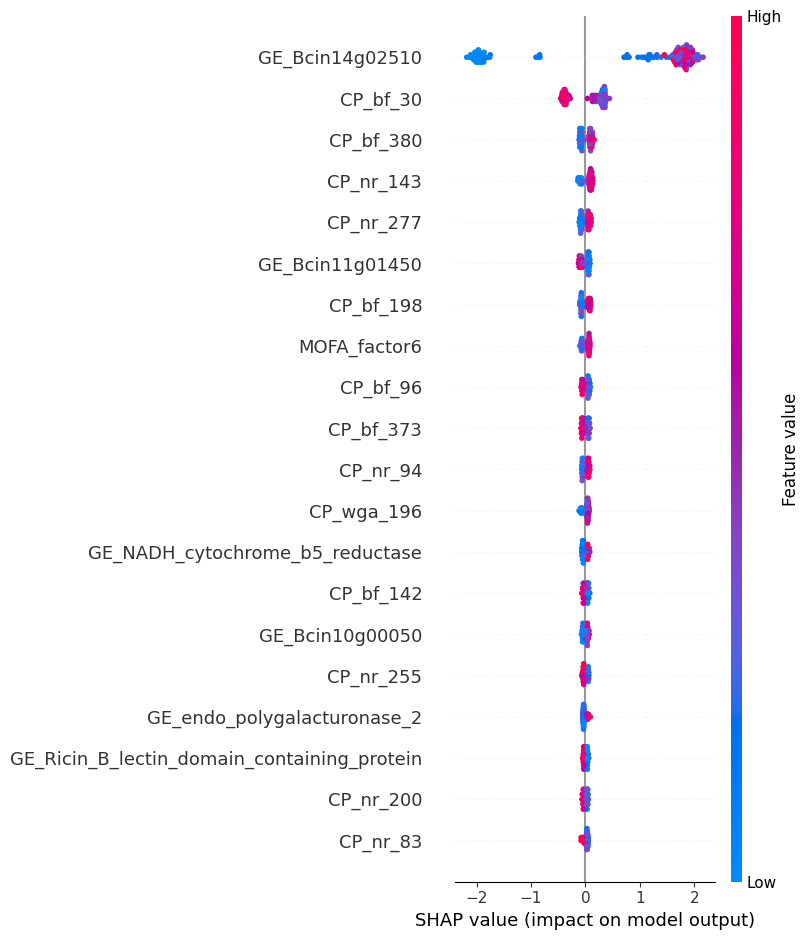

In [12]:
for moa_class in y_test.unique():
    if moa_class == "DMSO":
        continue
    train_class_vs_dmso(X_train, y_train, X_test, y_test, moa_class)